### Problem Statement: HDB ChatBox
Manually check all the information is very time consuming and the HFE letter take at least 1 month to know your eligibility.

A chatbot powered by Retrieval-Augmented Generation (RAG) can significantly improve customer support by:

Retrieving relevant answers from the Standard Chartered FAQs.

Generating natural and context-aware responses using an LLM.


Data Source: HDB residential website (https://www.hdb.gov.sg/cs/infoweb/residential/buying-a-flat)

This structured information provides authoritative answers to common customer inquiries.
Using RAG: Instead of relying solely on an LLM (which may hallucinate or provide inaccurate responses), we retrieve the most relevant FAQ content and let the LLM generate a well-structured response.
Why RAG is a Good Fit?
Ensures accuracy by retrieving up-to-date, bank-approved information.
Improves response coherence by allowing an LLM to rephrase retrieved data into conversational, user-friendly answers.
Handles diverse customer queries while maintaining consistency with official policies.



### Using Langchain dependencies:


  

In [ ]:
# %pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

Note: you may need to restart the kernel to use updated packages.



### Using LangSmith for inspection



In [1]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()



## Components

We will need to select three components from LangChain's suite of integrations.

import ChatModelTabs from "@theme/ChatModelTabs";

<ChatModelTabs customVarName="llm" />


In [4]:
import getpass
import os

# %pip install -U langchain-groq

if not os.environ.get("GROQ_API_KEY"):
  os.environ["GROQ_API_KEY"] = getpass.getpass("Enter API key for Groq: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("llama3-8b-8192", model_provider="groq")

import EmbeddingTabs from "@theme/EmbeddingTabs";

<EmbeddingTabs/>

In [5]:
%pip install -qU langchain-huggingface

from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

Note: you may need to restart the kernel to use updated packages.


/Users/wanluhuang/Desktop/DSA4265/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


import VectorStoreTabs from "@theme/VectorStoreTabs";

<VectorStoreTabs/>


## 1. Indexing

### Loading documents


Create Knowledge Graph

Methods tried that did not work:

Greedy Modularity Communities (Modularity Maximization): the graph is very sparse, resulting in isolated nodes and small communities that lack meaningful structure.

Dependency Parsing for Relationship Extraction: Dependency parsing only captures grammatical relationships, missing broader, semantic connections between nodes. It doesn't account for conceptual similarities.

What we did instead:

Sentence Embeddings for Graph Construction: We used sentence embeddings to build a graph where nodes (text chunks) are connected based on semantic similarity, allowing for more meaningful relationships.

Modularity Maximization on Semantic Graph: With the semantically rich graph, we applied modularity maximization again to detect larger, cohesive communities based on shared semantic themes

Graph Layout Adjustment: adjusted the k value in the spring_layout for a larger spread to avoid overcrowding.

In [6]:
# #Install necessary packages
%pip install langchain pypdf spacy networkx matplotlib sentence-transformers
!python -m spacy download en_core_web_sm  

  Using cached pypdf-5.4.0-py3-none-any.whl.metadata (7.3 kB)
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached weasel-0.4.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached typer-0.15.2-py3-none-any.whl.metadata (15 kB)
  Using cached langcodes-3.5.0-py3-none-any.whl.metadata (29 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached language_data-1.3.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached confection-0.1.5-py3-none-any.whl.metadata (19 kB)
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached cloudpathlib-0.21.0-py3-none-any.whl.metadata (14 kB)
  Using 

In [7]:
import os
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document
from collections import defaultdict
from sentence_transformers import SentenceTransformer
from networkx.algorithms.community import modularity_max
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [7]:
# from langchain.document_loaders import WebBaseLoader
# import bs4

# loader = WebBaseLoader(
#     web_paths=("https://www.sc.com/sg/help/faqs/bank-with-us-faqs/",),
# )
# docs = loader.load()


Sample chunk metadata: {'producer': 'Skia/PDF m134', 'creator': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/134.0.0.0 Safari/537.36', 'creationdate': '2025-03-28T06:38:25+00:00', 'title': 'HDB | Seniors', 'moddate': '2025-03-28T06:38:25+00:00', 'source': 'HDB_docs/HDB_Seniors.pdf', 'total_pages': 6, 'page': 0, 'page_label': '1', 'start_index': 0}


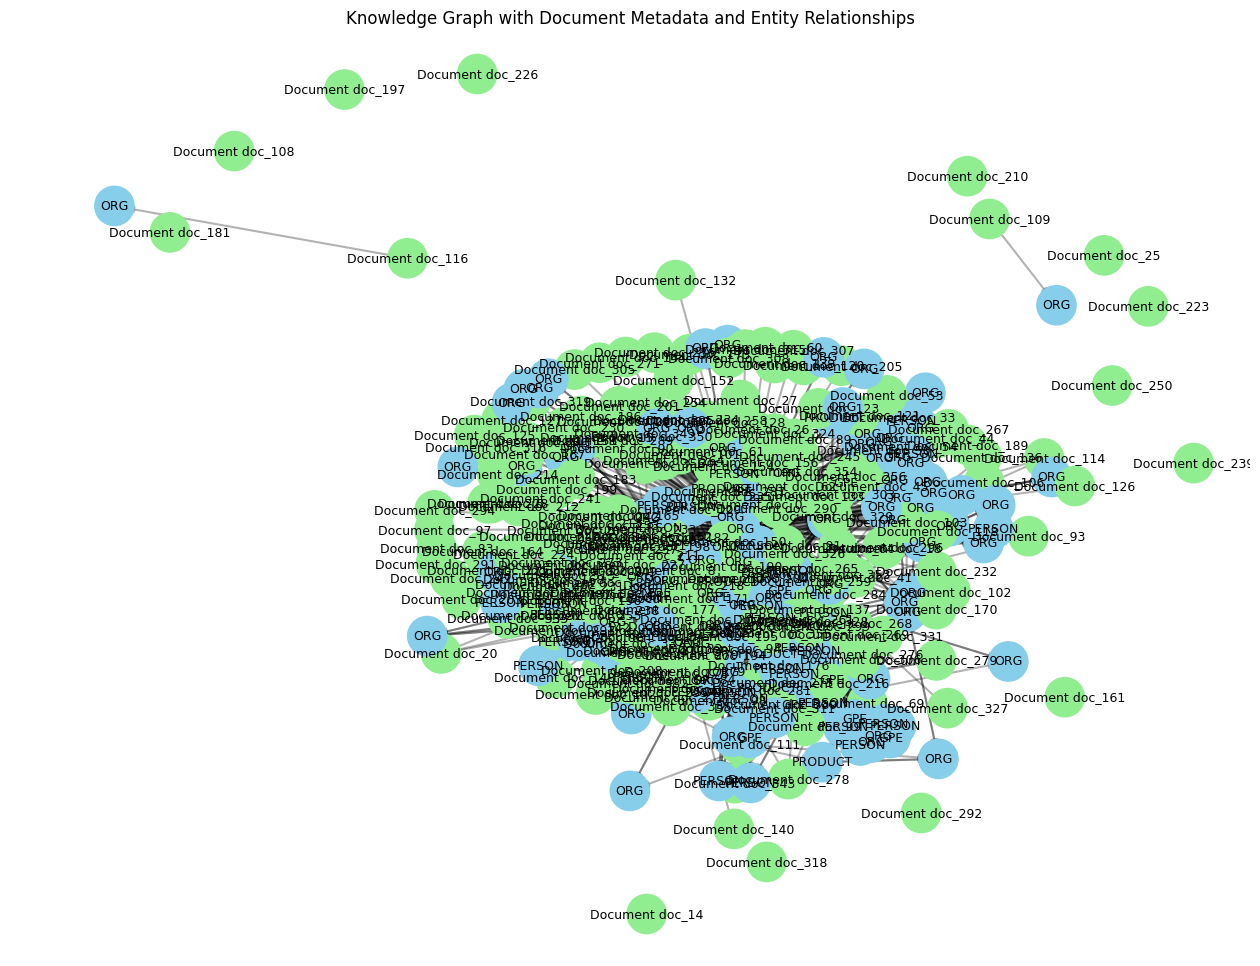

In [11]:
# Load NLP model and sentence transformer model
nlp = spacy.load("en_core_web_sm")
sentence_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Step 1: Load Documents with Metadata Preservation

folder_path = "HDB_docs"  # put your own file path to the HDB docs
all_docs = []

for filename in os.listdir(folder_path):
    if filename.endswith(".pdf"):
        file_path = os.path.join(folder_path, filename)
        loader = PyPDFLoader(file_path)
        docs = loader.load()

        # Add source metadata to all pages
        for doc in docs:
            doc.metadata['source'] = file_path  # Ensure source is preserved
        all_docs.extend(docs)

# Step 2: Text Chunking with Metadata Inheritance

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,
    chunk_overlap=150,  # Reduced from 300
    add_start_index=True,
    separators=["\n\n\n", "\n\n", "(?<=\\. )", " "]  # Better sentence-aware splits
)
all_splits = text_splitter.split_documents(all_docs)

# Verify metadata in splits
print("Sample chunk metadata:", all_splits[0].metadata)

# Step 3: Entity Extraction with Coreference Resolution
def extract_entities(text):
    doc = nlp(text)
    entities = {}
    for ent in doc.ents:
        if ent.label_ in {"ORG", "GPE", "PERSON", "EVENT", "PRODUCT"}:
            # Normalize entity text and handle coreferences
            clean_ent = ent.text.strip().replace('\n', ' ')
            entities[clean_ent] = ent.label_
    return entities

# Step 4: Relationship Extraction with Context Awareness
def extract_relationships(chunks):
    relations = []
    for chunk in chunks:
        entities = list(extract_entities(chunk.page_content).keys())
        # Create bidirectional relationships with context
        for i in range(len(entities)):
            for j in range(i+1, len(entities)):
                relations.append((entities[i], "related_to", entities[j]))
                relations.append((entities[j], "related_to", entities[i]))  # Bidirectional
    return relations

# Step 5: Knowledge Graph Construction with Full Metadata
knowledge_graph = nx.DiGraph()
entity_mapping = {}

for chunk in all_splits:

    # Preserve metadata with fallbacks
    metadata = chunk.metadata.copy()
    metadata.setdefault('source', 'Unknown')
    metadata.setdefault('page', 0)

    # Document node with full metadata
    doc_embedding = sentence_model.encode(chunk.page_content)
    doc_node_id = f"doc_{len(knowledge_graph.nodes)}"
    knowledge_graph.add_node(
        doc_node_id,
        type="document",
        embedding=doc_embedding,
        content=chunk.page_content,
        metadata=metadata,  # ✅ Store all metadata
        label=f"Document {doc_node_id}"
    )

    # Entity handling with normalization
    entities = extract_entities(chunk.page_content)
    for entity, label in entities.items():
        clean_entity = entity.strip().replace('\n', ' ')
        if clean_entity not in entity_mapping:
            knowledge_graph.add_node(
                clean_entity,
                label=label,
                type="entity"
            )
            entity_mapping[clean_entity] = label

        # Connect document to entity
        knowledge_graph.add_edge(
            doc_node_id, clean_entity,
            relation="mentions",
            weight=1.0
        )

    # Add entity relationships
    for source, rel, target in extract_relationships([chunk]):
        clean_source = source.strip().replace('\n', ' ')
        clean_target = target.strip().replace('\n', ' ')
        if clean_source in entity_mapping and clean_target in entity_mapping:
            knowledge_graph.add_edge(
                clean_source, clean_target,
                relation=rel,
                weight=1.0
            )

# Step 6: Community Detection with Enhanced Visualization
def detect_communities():
    return list(nx.algorithms.community.louvain_communities(knowledge_graph))

def visualize_graph():
    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(knowledge_graph, k=0.2, seed=42)

    # Node styling
    node_colors = []
    for node in knowledge_graph.nodes():
        if 'document' in knowledge_graph.nodes[node].get('type', ''):
            node_colors.append('lightgreen')
        else:
            node_colors.append('skyblue')

    nx.draw_networkx_nodes(knowledge_graph, pos, node_size=800, node_color=node_colors)
    nx.draw_networkx_edges(knowledge_graph, pos, alpha=0.3, width=1.5)

    # Label formatting
    labels = {n: d.get('label', n) for n, d in knowledge_graph.nodes(data=True)}
    nx.draw_networkx_labels(knowledge_graph, pos, labels, font_size=9)

    plt.title("Knowledge Graph with Document Metadata and Entity Relationships")
    plt.axis('off')
    plt.show()

if len(knowledge_graph.nodes) > 0:
    visualize_graph()

## 2. Retrieval and Generation


We’ll use a prompt for RAG that is checked into the LangChain prompt hub
([here](https://smith.langchain.com/hub/rlm/rag-prompt)).

In [ ]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

/Users/wanluhuang/Desktop/DSA4265/.venv/lib/python3.11/site-packages/langsmith/client.py:278: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


/Users/wanluhuang/Desktop/DSA4265/.venv/lib/python3.11/site-packages/langsmith/client.py:278: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Failed to multipart ingest runs: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=57ed1b62-356c-4f59-b89b-7cfa3ebeaa9b,id=57ed1b62-356c-4f59-b89b-7cfa3ebeaa9b
Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthErro

We'll use [LangGraph](https://langchain-ai.github.io/langgraph/) to tie together the retrieval and generation steps into a single application.


To use LangGraph, we need to define three things:

1. The state of our application;
2. The nodes of our application (i.e., application steps);
3. The "control flow" of our application (e.g., the ordering of the steps).

#### State:

The [state](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of our application controls what data is input to the application, transferred between steps, and output by the application.
For a simple RAG application, we can just keep track of the input question, retrieved context, and generated answer:

In [ ]:
# %pip install -q langgraph

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [14]:
# Function to simulate retrieval from the graph (instead of InMemoryVectorStore)
from langchain.docstore.document import Document
from typing import TypedDict, List, Tuple
import numpy as np
import hashlib
from collections import defaultdict
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langchain_core.runnables import Runnable

class State(TypedDict):
    question: str
    context: List[tuple[Document, float]]  # ✅ Store both document and score
    answer: str
# class State(TypedDict):
#     messages: List[str]                           # Conversation history
#     question: str                                 # Current user input
#     context: List[Tuple[Document, float]]         # Retrieved documents
#     profile: dict                                 # User profile (age, income, etc.)   


#### Nodes



In [15]:
# Function to simulate retrieval from the graph (instead of InMemoryVectorStore)
from langchain.docstore.document import Document
import numpy as np
import hashlib
from collections import defaultdict
def retrieve(state: State):
    """Full retrieve function with proper variable scoping"""
    question = state["question"]
    content_hashes = set()
    source_groups = defaultdict(list)

    # 1. Encode question
    question_embed = sentence_model.encode(question)

    # 2. Search knowledge graph
    for node_id, node_data in knowledge_graph.nodes(data=True):
        if node_data.get('type') != 'document':
            continue

        # 3. Extract document data
        content = node_data.get('content', '')
        metadata = node_data.get('metadata', {'source': 'Unknown', 'page': 0})
        doc_embed = node_data.get('embedding')

        # 4. Skip invalid embeddings
        if doc_embed is None or np.array(doc_embed).size == 0:
            continue

        # 5. Calculate similarity
        similarity = cosine_similarity(
            question_embed.reshape(1, -1),
            np.array(doc_embed).reshape(1, -1)
        )[0][0]

        # 6. Create document object
        doc = Document(
            page_content=content,
            metadata=metadata.copy()
        )

        # 7. Deduplication
        content_hash = hashlib.md5(content.strip().encode()).hexdigest()
        if content_hash in content_hashes:
            continue
        content_hashes.add(content_hash)

        # 8. Group by source section
        group_key = f"{metadata['source']}-{metadata.get('start_index',0)//1000}"
        source_groups[group_key].append((doc, similarity))

    # 9. Process groups into final results ✅ NOW PROPERLY DEFINED
    final_results = []
    for group in source_groups.values():
        if not group:
            continue
        best_match = max(group, key=lambda x: x[1])
        if best_match[1] > 0.3:  # Similarity threshold
            final_results.append(best_match)

    # 10. Sort and return
    final_results.sort(key=lambda x: x[1], reverse=True)
    return {"context": final_results[:3]}
# Generate the response based on the retrieved context
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc, _ in state["context"])  # Extract document content
    messages = prompt.invoke({"question": state["question"], "context": docs_content})  # Pass the context to the prompt
    response = llm.invoke(messages)  # Invoke the LLM to generate an answer
    return {"answer": response.content}



#### Control flow

Finally, we compile our application into a single `graph` object. In this case, we are just connecting the retrieval and generation steps into a single sequence.

In [16]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()


LangGraph also comes with built-in utilities for visualizing the control flow

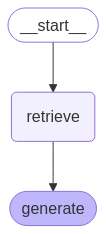

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

#### Usage


In [18]:
from langgraph.graph import START, StateGraph

# Example query
result = graph.invoke({"question": "How do I qualify to buy a new HDB flat?"})

# Process and display the results
print("🟢" * 50)
print(f"QUESTION: {result['question']}\n")
print(f"ANSWER: {result['answer']}\n")

print("🔍 CONTEXT USED:")

# Ensure the context exists and is in the expected format
context_data = result.get("context", [])

if context_data and isinstance(context_data[0], tuple):
    # ✅ Properly handle (Document, score) tuples
    for i, (doc, score) in enumerate(context_data[:3]):  # Show top 3 context chunks
        cleaned_content = doc.page_content.replace('\n', ' ').strip()[:500]  # Clean text
        print(f"\n{'━' * 40}")
        print(f"CONTEXT CHUNK {i+1}:")
        print(f"Source: {doc.metadata.get('source', 'Unknown')}")
        print(f"Similarity Score: {score:.4f}")  # Display similarity score
        print(f"Content Preview:\n{cleaned_content}...\n")

elif context_data and isinstance(context_data[0], Document):
    # 🛑 Fallback: If retrieval failed to return scores, warn the user
    print("⚠️ Warning: Similarity scores missing. Showing document chunks only.")
    for i, doc in enumerate(context_data[:3]):
        cleaned_content = doc.page_content.replace('\n', ' ').strip()[:500]
        print(f"\n{'━' * 40}")
        print(f"CONTEXT CHUNK {i+1}:")
        print(f"Source: {doc.metadata.get('source', 'Unknown')}")
        print(f"Content Preview:\n{cleaned_content}...\n")

else:
    print("❌ No relevant documents found.")

print("🟢" * 50)

🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢
QUESTION: How do I qualify to buy a new HDB flat?

ANSWER: To qualify to buy a new HDB flat, you need to meet certain criteria, such as buying a flat type with a net purchase price of $500,000 or above, or applying for a flat that is bigger than a 5-room flat. You do not need prior consent from the OA or private trustee if you are listed as an occupier of a flat. However, if you are an undischarged bankrupt, you must obtain prior consent from the OA or private trustee to apply for a flat.

🔍 CONTEXT USED:

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
CONTEXT CHUNK 1:
Source: HDB_docs/HDB_Singles.pdf
Similarity Score: 0.6207
Content Preview:
private trustee, to apply to buy: An HDB flat that is bigger than a 5-room flat Any flat type with a net purchase price of $500,000 or above, after taking into account any HDB subsidies or levy You do not need to seek prior consent from the OA or the private trustee if you are listed as an occupier of a


####  If we want to customize the prompt later, we can use the following


In [19]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

## Now that we have a basic RAG, one common problem arise when users ask vague questions, or questions outside of the context
If we're working with a similarity search-based index, like a vector store, then searching on raw questions may not work well because their embeddings may not be very similar to those of the relevant documents.

Instead it might help to have the model generate a hypothetical relevant document, and then use that to perform similarity search. One way to tackle this problem is by using Hypothetical Document Embedding (HyDE)

HyDE is a technique that combines two types of embeddings:

Traditional term-based embeddings (like TF-IDF or BM25) that focus on exact matches of terms or keywords in documents.

Contextual embeddings (like those from transformer-based models) that focus on the semantic meaning and context of words, even when they don’t appear exactly in the text.

Therefore, in my opinion, HyDE is a form of hybrid retrieval, and probably better than pure hybrid retrieval method. If given more time we could try combining HyDE with a pure hybrid retrieval approach (for example, adding BM25) for fine-grained control or performance optimization.

## Query Decomposition and Augmentation

In [20]:
def decompose_question(query: str) -> list:
    """
    Decomposes the user's query into structured sub-questions.
    Removes instructions, headings, and filters for actual question lines.
    """
    prompt = f"""
    Decompose the following user query into clear, sequential sub-questions
    related to HDB flat eligibility, schemes, or grants.

    Query: "{query}"

    Return the list as plain numbered questions.
    """

    messages = [
        {"role": "system", "content": "You are a helpful HDB policy assistant."},
        {"role": "user", "content": prompt}
    ]

    response = llm.invoke(messages)
    lines = response.content.strip().split("\n")

    # ✅ Filter lines that look like actual questions
    sub_questions = [
        line.strip().lstrip("1234567890. ").strip()
        for line in lines
        if "?" in line and len(line.strip()) > 5  # filter short or non-question lines
    ]

    return sub_questions

In [21]:
query = "I’m 25, single, Singaporean, and earning $3200. Can I buy a flat and what grants can I apply for?"

sub_questions = decompose_question(query)

for i, q in enumerate(sub_questions, 1):
    print(f"{i}. {q}")

1. Am I eligible to buy a HDB flat as a single person?
2. Are there any specific income limits for singles applying to buy a HDB flat?
3. Can I apply for a HDB flat as a Singaporean citizen?
4. What is the minimum income required to be eligible for a HDB flat?
5. Considering my income of $3200, am I eligible for a HDB flat under the current income limits?
6. What are the available grants for first-time flat buyers in Singapore?
7. Am I eligible for any additional grants or schemes as a single person?
8. Are there any specific requirements or conditions to fulfill to be eligible for these grants?
9. What are the potential options for flat types and locations that I can consider given my income and eligibility status?


In [22]:
def augment_query(query: str) -> str:
    """
    Uses the LLM to fill in missing context from vague user queries.
    Example: 'Can I apply?' becomes 'Can a 29-year-old single Singaporean earning $3200 apply for an HDB flat?'
    """
    messages = [
        {"role": "system", "content": "You are a helpful HDB policy assistant who rewrites vague queries by adding assumptions."},
        {"role": "user", "content": f"Rewrite the following vague question into a detailed one with assumptions: {query}"}
    ]

    response = llm.invoke(messages)
    return response.content.strip()

## Retrieval and Generation with HyDE

In [23]:
from typing import List, Tuple, Optional
from langchain_core.documents import Document
import numpy as np

class State(TypedDict):
    question: str
    hypothetical_doc: Optional[str]
    context: List[Tuple[Document, float]]  # (Document chunk, similarity score)
    answer: Optional[str]

def generate_hypothetical_answer(state: State):
    """Generate hypothetical document using LLM"""
    messages = [
        {"role": "system", "content": "Generate a possible answer as a document excerpt. Include entities and relationships."},
        {"role": "user", "content": state["question"]}
    ]
    response = llm.invoke(messages)
    return {"hypothetical_doc": response.content}

def retrieve(state: State):
    """Graph-based retrieval using HyDE embedding"""
    hypothetical_answer = state["hypothetical_doc"]

    # 1. Encode HyDE document
    hyde_embedding = sentence_model.encode(hypothetical_answer)

    # 2. Search knowledge graph nodes
    candidates = []
    for node_id, node_data in knowledge_graph.nodes(data=True):
        if node_data.get('type') == 'document':
            doc_embed = node_data.get('embedding')
            if doc_embed is None:
                continue

            # 3. Calculate similarity
            similarity = cosine_similarity(
                hyde_embedding.reshape(1, -1),
                np.array(doc_embed).reshape(1, -1)
            )[0][0]

            # 4. Create Document with graph metadata
            doc = Document(
                page_content=node_data.get('content', ''),
                metadata={
                    **node_data.get('metadata', {}),
                    'graph_entities': [
                        (n, knowledge_graph.nodes[n].get('label'))
                        for n in knowledge_graph.neighbors(node_id)
                        if knowledge_graph.nodes[n].get('type') == 'entity'
                    ]
                }
            )
            candidates.append((doc, similarity))

    # 5. Deduplicate and sort
    unique_docs = {}
    for doc, score in candidates:
        content_hash = hashlib.md5(doc.page_content.encode()).hexdigest()
        if content_hash not in unique_docs or score > unique_docs[content_hash][1]:
            unique_docs[content_hash] = (doc, score)

    sorted_results = sorted(unique_docs.values(), key=lambda x: x[1], reverse=True)
    return {"context": sorted_results[:5]}  # Return top 5 graph-connected docs

def generate(state: State):
    """Generate answer using graph context"""
    context_str = "\n\n".join([
        f"Document [Source: {doc.metadata.get('source', 'Unknown')}]:\n{doc.page_content}\n"
        f"Connected Entities: {', '.join([f'{e[0]} ({e[1]})' for e in doc.metadata.get('graph_entities', [])])}"
        for doc, _ in state["context"]
    ])

    messages = [
        {"role": "system", "content": f"""Answer using this graph-connected context:
        {context_str}"""},
        {"role": "user", "content": state["question"]}
    ]
    response = llm.invoke(messages)
    return {"answer": response.content}

# Build enhanced workflow
workflow = StateGraph(State)
workflow.add_node("generate_hypothesis", generate_hypothetical_answer)
workflow.add_node("retrieve", retrieve)
workflow.add_node("generate", generate)

workflow.set_entry_point("generate_hypothesis")
workflow.add_edge("generate_hypothesis", "retrieve")
workflow.add_edge("retrieve", "generate")

app = workflow.compile()


In [24]:
# Step 1: Vague user question
raw_query = "Can I apply for a flat?"

# Step 2: Augment with graph-aware expansion
def augment_query(query: str) -> str:
    """Enhance query using graph entity recognition"""
    doc = nlp(query)
    entities = [ent.text for ent in doc.ents
               if ent.label_ in {"ORG", "GPE", "PRODUCT"}]

    augmented = f"{query} Regarding Singapore public housing"
    if entities:
        augmented += f" specifically about {', '.join(entities)}"
    return augmented

augmented_query = augment_query(raw_query)

# Step 3: Decompose using graph schema
def decompose_question(query: str) -> List[str]:
    """Break down using known entity relationships"""
    base_questions = [
        "What are the eligibility criteria for {query}?",
        "What documents are needed to apply for {query}?",
        "What are the financial requirements for {query}?"
    ]
    return [q.format(query=query) for q in base_questions]

sub_questions = decompose_question(augmented_query)

# ---------------- Enhanced Print Functions ----------------
def print_divider(char="─", length=80):
    print(f"\n{char * length}")

def print_header(text: str, emoji: str = "🔍"):
    print(f"\n{emoji} {text.upper()} {emoji}")

def format_entities(entities: list, limit: int = 3) -> str:
    if not entities:
        return "No connected entities found"
    return "\n".join([f"• {ent[0]} ({ent[1]})" for ent in entities[:limit]])
# -----------------------------------------------------------

print("🟢" * 50)

# Step 4: Execute graph-enhanced HyDE pipeline
for i, q in enumerate(sub_questions, 1):
    result = app.invoke({
        "question": q,
        "hypothetical_doc": None,
        "context": [],
        "answer": None
    })

    print_divider("═", 60)
    print_header(f"Processing Pipeline - Subquestion {i}", "📌")
    print(f"Original Query:   {raw_query}")
    print(f"Augmented Query:  {q}")

    # Hypothetical Document Section
    print_header("Generated Hypothetical Document", "📄")
    print(f"{result['hypothetical_doc'][:250]}..." + "\n" + "-"*40)
    print(f"Document Length: {len(result['hypothetical_doc'].split())} words")

    # Context and Entities Section
    if result['context']:
        print_header("Knowledge Graph Connections", "🔗")
        main_doc, score = result['context'][0]
        print(f"Top Match Score: {score:.3f}")
        print(f"Source Document: {main_doc.metadata.get('source', 'Unknown')}")

        entities = main_doc.metadata.get('graph_entities', [])
        print_header("Connected Entities", "🌐")
        print(format_entities(entities))

    # Final Answer Section
    print_header("Generated Answer", "💡")
    print(f"\n{result['answer']}\n")
    print("-"*40)
    print(f"Answer Length: {len(result['answer'].split())} words\n")

print("🟢" * 50)

🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢

════════════════════════════════════════════════════════════

📌 PROCESSING PIPELINE - SUBQUESTION 1 📌
Original Query:   Can I apply for a flat?
Augmented Query:  What are the eligibility criteria for Can I apply for a flat? Regarding Singapore public housing?

📄 GENERATED HYPOTHETICAL DOCUMENT 📄
**Excerpt from HDB's Eligibility Criteria for Public Housing Flats in Singapore**

The Housing and Development Board (HDB) is Singapore's public housing authority, responsible for providing affordable housing to citizens and permanent residents. To a...
----------------------------------------
Document Length: 310 words

🔗 KNOWLEDGE GRAPH CONNECTIONS 🔗
Top Match Score: 0.732
Source Document: HDB_docs/HDB_Enhanced_CPF_Housing_Grant_(Families).pdf

🌐 CONNECTED ENTITIES 🌐
• Criteria Details (PERSON)
• Household Assistance (PERSON)
• HDB (ORG)

💡 GENERATED ANSWER 💡

According to the documents provided, here are the eligibility criteria for applyin

## Add the Planning Agent

LangChain supports memory — but the default memory only stores chat history, not structured data like:

User’s age

Income

Marital status

Preferred flat type

To fix your issue, you want Structured Memory, like a key-value store.

## redefine reteieve accordingly

In [25]:
def retrieve(state: State):
    """Graph-based retrieval using HyDE embedding"""
    question = state["question"]
    
    # Generate HyDE-style hypothetical answer
    hypothetical_answer = llm.invoke(f"Answer this question as best as you can:\n{question}").content
    
    # Encode hypothetical answer for similarity search
    hyde_embedding = sentence_model.encode(hypothetical_answer)
    
    content_hashes = set()
    source_groups = defaultdict(list)

    # Graph search
    for node_id, node_data in knowledge_graph.nodes(data=True):
        if node_data.get('type') != 'document':
            continue

        doc_embed = node_data.get('embedding')
        content = node_data.get('content', '')
        metadata = node_data.get('metadata', {})

        if doc_embed is None or np.array(doc_embed).size == 0:
            continue

        similarity = cosine_similarity(
            hyde_embedding.reshape(1, -1),
            np.array(doc_embed).reshape(1, -1)
        )[0][0]

        doc = Document(page_content=content, metadata=metadata.copy())
        content_hash = hashlib.md5(content.strip().encode()).hexdigest()
        if content_hash in content_hashes:
            continue
        content_hashes.add(content_hash)

        group_key = f"{metadata.get('source', 'unknown')}-{metadata.get('start_index',0)//1000}"
        source_groups[group_key].append((doc, similarity))

    final_results = []
    for group in source_groups.values():
        if group:
            best_match = max(group, key=lambda x: x[1])
            if best_match[1] > 0.3:
                final_results.append(best_match)

    final_results.sort(key=lambda x: x[1], reverse=True)
    return {"context": final_results[:3]}


add a smart router that decides when to:

Use 🔧 Agent tools (for rule-based eligibility logic)

Or use 📚 LangGraph (for document-based questions)

In [26]:
def route_query(query: str) -> str:
    """
    Simple keyword-based router to decide between tools and LangGraph.
    You can improve this later with an LLM-based classifier.
    """
    tool_keywords = ["age", "income", "single", "married", "grant", "fiancé", "divorced", "scheme", "eligibility"]

    if any(kw in query.lower() for kw in tool_keywords):
        return "tool"
    return "graph"

## Upgrade the Age Check Tool to Real Logic (Can improve this part later on to complete the logic)

In [ ]:
from typing import List, Tuple, Optional, TypedDict
from langchain_core.documents import Document
import re
from collections import defaultdict
import hashlib
from difflib import SequenceMatcher
from sklearn.metrics.pairwise import cosine_similarity

# ---- LLM and sentence model (must be defined beforehand) ----
# llm = ChatOpenAI()
# sentence_model = SentenceTransformer(...)
# knowledge_graph = your NetworkX graph with embedded document nodes

# ---- Shared memory structure ----
user_profile = {
    "age": None,
    "income": None,
    "flat_type": None,
    "relationship_status": None,
}

# ---- LangGraph-compatible State ----
class State(TypedDict):
    question: str
    hypothetical_doc: Optional[str]
    context: List[Tuple[Document, float]]
    answer: Optional[str]
    messages: List[str]

# ---- User profile utilities ----
def extract_age(query: str):
    match = re.search(r'\b(?:i am|i’m|im)?\s*(\d{2})\s*(?:years old|y/o|yo|yrs)?\b', query.lower())
    return int(match.group(1)) if match else None
    
def extract_income(query: str):
    match = re.search(r'\$?\s?(\d{3,5})', query)
    return int(match.group(1)) if match else None

def extract_relationship(query: str):
    q = query.lower()
    if any(w in q for w in ["fiance", "fiancée"]): return "fiance"
    if any(w in q for w in ["married", "spouse", "wife", "husband"]): return "married"
    if "divorced" in q: return "divorced"
    if "widowed" in q or "orphan" in q: return "widowed"
    if "single" in q: return "single"
    return None

def extract_flat_type(query: str):
    q = query.lower()
    
    # Handle both / open-ended cases
    if any(word in q for word in ["both", "not sure", "unsure", "either", "any"]):
        return "both"
    
    if "bto" in q:
        return "bto"
    if "resale" in q:
        return "resale"
    
    return None


def update_user_profile(query: str):
    user_profile["age"] = extract_age(query) or user_profile["age"]
    user_profile["income"] = extract_income(query) or user_profile["income"]
    user_profile["relationship_status"] = extract_relationship(query) or user_profile["relationship_status"]
    user_profile["flat_type"] = extract_flat_type(query) or user_profile["flat_type"]

def ask_missing_fields():
    prompts = {
        "age": "🔎 What is your age? ",
        "income": "💰 What is your monthly income? ",
        "relationship_status": "❤️ What is your relationship status? ",
        "flat_type": "🏠 Are you interested in a BTO or resale flat? ",
    }
    
    for key, prompt in prompts.items():
        if not user_profile[key]:
            response = input(prompt)
            update_user_profile(response)



## Add Hybrid Memory Support


In [ ]:
from langchain.memory import ConversationBufferMemory
import json
import os

# 1. Short-term memory (conversation tracking)
chat_memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

# 2. Long-term memory persistence (user profile)
PROFILE_PATH = "user_profile.json"

def save_user_profile():
    with open(PROFILE_PATH, "w") as f:
        json.dump(user_profile, f)

def load_user_profile():
    global user_profile
    if os.path.exists(PROFILE_PATH):
        with open(PROFILE_PATH, "r") as f:
            user_profile = json.load(f)
        print("✅ User profile loaded.")
    else:
        print("ℹ️ No saved profile found. Using defaults.")

# Load profile at startup
load_user_profile()

In [ ]:
# ---- LangGraph nodes ----
def generate_hypothetical_node(state: State) -> State:
    profile = user_profile
    flat = profile.get("flat_type")

    # 🔀 Flat type context handling
    if flat == "bto":
        flat_context = "The user is interested in a BTO flat."
    elif flat == "resale":
        flat_context = "The user is interested in a resale flat."
    elif flat == "both":
        flat_context = (
            "The user is open to both BTO and resale flats. "
            "If policies differ, simulate an answer that includes both perspectives."
        )
    else:
        flat_context = (
            "The user has not specified flat type. "
            "Please simulate an answer that covers both BTO and resale paths if relevant."
        )

    # 📋 Full profile summary
    profile_summary = f"""User Profile:
- Age: {profile.get('age')}
- Income: {profile.get('income')}
- Relationship: {profile.get('relationship_status')}
- Flat Type: {flat or 'unspecified'}

{flat_context}
"""

    # 🧠 HyDE generation prompt
    response = llm.invoke([
        {"role": "system", "content": f"Generate a hypothetical answer as if it came from a government housing policy document. Use the user's profile below:\n\n{profile_summary}"},
        {"role": "user", "content": state["question"]}
    ])
    
    state["hypothetical_doc"] = response.content
    return state



def retrieve_node(state: State) -> State:
    hyde_embedding = sentence_model.encode(state["hypothetical_doc"])
    results = []
    seen_hashes = set()
    for node_id, node_data in knowledge_graph.nodes(data=True):
        if node_data.get('type') != 'document': continue
        doc_embed = node_data.get('embedding')
        if doc_embed is None: continue
        score = cosine_similarity(
            hyde_embedding.reshape(1, -1), 
            doc_embed.reshape(1, -1)
        )[0][0]
        doc = Document(
            page_content=node_data.get('content', ''),
            metadata=node_data.get('metadata', {})
        )
        hash_ = hashlib.md5(doc.page_content.encode()).hexdigest()
        if hash_ not in seen_hashes:
            results.append((doc, score))
            seen_hashes.add(hash_)
    results.sort(key=lambda x: x[1], reverse=True)
    state["context"] = results[:3]
    return state

def generate_node(state: State) -> State:
    context_text = "\n\n".join([doc.page_content for doc, _ in state["context"]])
    # history = "\n".join(state.get("messages", [])[-5:])
    history = chat_memory.load_memory_variables({}).get("chat_history", "")
    
    # ✅ Add profile logic
    profile = user_profile
    flat = profile.get("flat_type")

    # 🔀 Flat type context handling
    if flat == "bto":
        flat_context = "The user is interested in a BTO flat."
    elif flat == "resale":
        flat_context = "The user is interested in a resale flat."
    elif flat == "both":
        flat_context = (
            "The user is open to both BTO and resale flats. "
            "If policies differ, explain both options side by side."
        )
    else:
        flat_context = (
            "The user has not specified BTO or resale. "
            "If the answer depends on flat type, explain both options clearly."
        )

    # 📋 Full profile summary to include in prompt
    profile_summary = f"""
User Profile:
- Age: {profile.get('age')}
- Income: {profile.get('income')}
- Relationship: {profile.get('relationship_status')}
- Flat Type: {flat or 'unspecified'}

{flat_context}
"""

    # 🧠 Prompt messages
    prompt = [
        {"role": "system", "content": f"""You are an HDB assistant. Use the following user profile and retrieved documents to answer accurately.

{profile_summary}

📚 Retrieved Context:
{context_text}

🧠 Chat History:
{history if history else "No prior chat history."}
""" },
        {"role": "user", "content": state['question']}
    ]
    
    response = llm.invoke(prompt)

    # Track conversation turn in memory
    chat_memory.save_context({"input": state["question"]}, {"output": response.content})

    state["answer"] = response.content
    return state



def fact_check_answer(answer: str, docs: List, threshold: float = 0.6) -> bool:
    answer_sentences = [s.strip() for s in answer.split('.') if len(s.strip()) > 10]

    # Gracefully handle both Document and (Document, score)
    cleaned_docs = [doc[0] if isinstance(doc, tuple) else doc for doc in docs]

    for sentence in answer_sentences:
        for doc in cleaned_docs:
            sim = SequenceMatcher(None, sentence.lower(), doc.page_content.lower()).ratio()
            if sim > threshold:
                return True
    return False


def fact_check_node(state: State) -> State:
    answer = state.get("answer", "")
    docs = [doc[0] if isinstance(doc, tuple) else doc for doc in state.get("context", [])]

    if not fact_check_answer(answer, docs):
        print("⚠️ Fact-check failed. Switching to safe RAG answer.")

        context_text = "\n\n".join(doc.page_content for doc in docs)

        # ✅ Reuse full user profile in fallback
        profile = user_profile
        flat = profile.get("flat_type")
        if flat == "bto":
            flat_context = "The user is interested in a BTO flat."
        elif flat == "resale":
            flat_context = "The user is interested in a resale flat."
        elif flat == "both":
            flat_context = (
                "The user is open to both BTO and resale options. "
                "If policies differ, explain both clearly."
            )
        else:
            flat_context = (
                "The user has not specified flat type. "
                "If relevant, explain both BTO and resale differences."
            )

        profile_summary = f"""
User Profile:
- Age: {profile.get('age')}
- Income: {profile.get('income')}
- Relationship: {profile.get('relationship_status')}
- Flat Type: {flat or 'unspecified'}

{flat_context}
"""

        fallback_prompt = [
            {"role": "system", "content": f"""You are an HDB assistant. Always answer based on the user profile and retrieved documents.

{profile_summary}

📚 Retrieved Context:
{context_text}
""" },
            {"role": "user", "content": state["question"]}
        ]

        fallback = llm.invoke(fallback_prompt)
        state["answer"] = fallback.content
    else:
        print("✅ Answer passed fact-check.")

    return state

## HyDE + Knowledge Graph + LLM + Memory + Fact-checking All stitched together with LangGraph

In [74]:
# ---- Build LangGraph ----
from langgraph.graph import StateGraph

workflow = StateGraph(State)
workflow.add_node("generate_hypothesis", generate_hypothetical_node)
workflow.add_node("retrieve", retrieve_node)
workflow.add_node("generate", generate_node)
workflow.add_node("fact_check", fact_check_node)

workflow.set_entry_point("generate_hypothesis")
workflow.add_edge("generate_hypothesis", "retrieve")
workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", "fact_check")
workflow.set_finish_point("fact_check")

graph = workflow.compile()

### unique serial ID to each user session and store the associated profile

In [75]:
import random
import string

# A dictionary to store user profiles keyed by serial
user_memory_store = {}

# Generate unique user ID (e.g., 6-char alphanumeric code)
def generate_user_id(length=6):
    return ''.join(random.choices(string.ascii_uppercase + string.digits, k=length))

In [76]:
def check_existing_user():
    print("🔁 Welcome back! If you're a returning user, enter your serial code. Otherwise, press Enter to start fresh.")
    user_input = input("🔑 Serial code: ").strip().upper()

    if user_input and user_input in user_memory_store:
        print(f"✅ Found your profile with ID {user_input}. Welcome back!")
        user_profile.update(user_memory_store[user_input])
        return user_input
    else:
        new_id = generate_user_id()
        print(f"🆕 New session started. Your serial code is: {new_id}")
        print("📌 Save this code to continue later with the same profile.")
        return new_id


In [ ]:
# ---- Interactive chatbot ----
chat_history = []

def interactive_chatbot():
    print("👋 Hello! I'm your HDB eligibility assistant.")
    session_id = check_existing_user()  # 🔑 New or returning?

    while True:
        query = input("\n🧑 You: ")
        if query.lower() in ["exit", "quit"]:
            # 💾 Save user profile
            user_memory_store[session_id] = user_profile.copy()
            print(f"📦 Profile saved under ID: {session_id}")
            print("👋 Goodbye! Use your serial next time to continue.")
            break

        update_user_profile(query)
        ask_missing_fields()
        save_user_profile()

        chat_history.append(f"User: {query}")

        result = graph.invoke({
            "question": query,
            "hypothetical_doc": None,
            "context": [],
            "answer": None,
            "messages": chat_history
        })

        answer = result["answer"]
        chat_history.append(f"Assistant: {answer}")

        print("\n🤖", answer)
        print(f"\n🧠 Current user profile (ID: {session_id}):", user_profile)


In [78]:
# # this is for the later use of LangGraph 
# def retrieve_node(state: State) -> State:
#     result = retrieve(state)
#     state["context"] = result["context"]
#     return state

# def generate_node(state: State) -> State:
#     result = generate(state)
#     state["answer"] = result["answer"]
#     return state

# def parse_and_extract_node(state: State) -> State:
#     query = state["question"]
#     update_user_profile(query)
#     state["profile"] = user_profile  # update profile inside state
#     return state
    
# graph_builder = StateGraph(State)

# # Add nodes
# graph_builder.add_node("parse_query", parse_and_extract_node)  # you should already have this
# graph_builder.add_node("retrieve", retrieve_node)
# graph_builder.add_node("generate_answer", generate_node)

# # Connect steps
# graph_builder.set_entry_point("parse_query")
# graph_builder.add_edge("parse_query", "retrieve")
# graph_builder.add_edge("retrieve", "generate_answer")
# graph_builder.set_finish_point("generate_answer")

# graph = graph_builder.compile()


In [79]:
# from langchain.agents import initialize_agent
# from langchain.agents.agent_types import AgentType

# agent = initialize_agent(
#     tools=tools,
#     llm=llm,  # 👈 This is your Groq-powered model
#     agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
#     verbose=True
# )

In [ ]:
interactive_chatbot()

👋 Hello! I'm your HDB eligibility assistant.
🔁 Welcome back! If you're a returning user, enter your serial code. Otherwise, press Enter to start fresh.


🔑 Serial code:  


🆕 New session started. Your serial code is: IVN88D
📌 Save this code to continue later with the same profile.


## Now that we have RAG with HyDE, we can further improve it by adding a Guardrail Verification to ensure the LLM-generated response is factually correct by cross-checking with retrieved documents.

We apply Guardrail verification layer after having HyDE to ensure LLM-generated responses remain accurate.

Combines HyDE + Guardrails to improve both retrieval quality and response reliability

In [24]:
import logging
from typing import List, TypedDict
from langchain.schema import Document
from langchain.schema.runnable import RunnableLambda

from transformers import pipeline


# Configure logging
logging.basicConfig(filename="guardrail_rejections.log", level=logging.INFO, format="%(asctime)s - %(message)s")

# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str
    attempts: int  # Track number of retry attempts


# Load NLI model for fact-checking
nli_pipeline = pipeline("text-classification", model="facebook/bart-large-mnli")

# Define application steps

def generate_hypothetical_answer(question: str) -> str:
    """Generate a hypothetical answer for the given question using LLM."""
    print("\n🔍 Generating a hypothetical question-based answer...")
    messages = [
        {"role": "system", "content": "Generate a possible answer to the following question:"},
        {"role": "user", "content": question}
    ]
    response = llm.invoke(messages)
    print(f"✨ Hypothetical Answer: {response.content}\n")
    return response.content  # Hypothetical answer

def retrieve(state: State):
    """Retrieve relevant documents based on a hypothetical answer."""
    hypothetical_answer = generate_hypothetical_answer(state["question"])
    retrieved_docs_with_scores = vector_store.similarity_search_with_score(hypothetical_answer)  # Use generated answer for retrieval

    print("📚 Retrieved Documents:")
    for idx, (doc, score) in enumerate(retrieved_docs_with_scores):
        print(f"Chunk {idx + 1}: {doc.page_content[:200]}...")  # Show only first 200 chars
        print(f"Similarity Score: {score:.4f}")  # Display similarity score

    return {"context": retrieved_docs_with_scores, "attempts": 0}  # Initialize retry count

def generate(state: State):
    """Generate the final answer using the retrieved documents."""
    docs_content = "\n\n".join(doc.page_content for doc, _ in state["context"])  # Get only document content
    messages = [
        {"role": "system", "content": "Use the following information to answer the question accurately:"},
        {"role": "user", "content": f"Context: {docs_content}\n\nQuestion: {state['question']}"}
    ]
    response = llm.invoke(messages)

    print("\n🤖 Generated Answer (before verification):")
    print(response.content)

    return {"answer": response.content}

def fact_check(state: State):
    """Cross-check LLM-generated response against retrieved documents to prevent hallucinations."""
    response = state["answer"]
    retrieved_docs = state["context"]
    attempts = state["attempts"]

    for doc, _ in retrieved_docs:
        check = nli_pipeline([f"Premise: {doc.page_content} Hypothesis: {response}"])
        label = check[0]["label"]

        if label == "contradiction":  # Response contradicts retrieved facts
            logging.info(f"❌ Rejected response: {response} | Question: {state['question']} | Attempt: {attempts}")
            print("\n⚠️ Hallucination detected! The answer contradicts the retrieved facts.")

            if attempts < 2:  # Retry up to 2 times
                print(f"🔄 Retrying response generation... (Attempt {attempts + 1})")
                state["attempts"] += 1
                return generate(state)  # Retry response generation

            print("🚨 Maximum retries reached. Returning a fallback response.")
            return {"answer": "I'm sorry, but I couldn't verify the accuracy of this information."}

    print("✅ Fact-check passed! The response aligns with retrieved documents.")
    return state  # Pass through if verified

# Compile application with Guardrail verification & retry mechanism
graph_builder = StateGraph(State).add_sequence([retrieve, generate, fact_check])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


In [25]:
test_question = "I think I made a payment to my credit card yesterday, but I'm not sure if it went through. How can I check if my payment was successful?"
response = graph.invoke({"question": test_question})

# Print final response
print("\n🎯 Final Validated Answer:")
print(response["answer"])




🔍 Generating a hypothetical question-based answer...
✨ Hypothetical Answer: You can check if your payment was successful by following these steps:

1. Log in to your online banking account: Go to your bank's website and log in to your online banking account using your username and password.
2. Check your account activity: Once you're logged in, click on the "Account Activity" or "Transaction History" tab to view a list of recent transactions.
3. Look for the payment: Search for the payment you made to your credit card by date, amount, or description. If you see the payment listed, it's likely that it was successful.
4. Check your credit card account: Log in to your credit card account online or through the mobile app to see if the payment has been applied to your account.
5. Check your bank statement: If you're unable to find the payment in your online banking activity, check your bank statement for the payment. It may take a few days for the payment to appear on your statement.
6. Co

📚 Retrieved Documents:
Chunk 1: How do I know that my bill payment transaction is successful?
The successful bill payment transaction will be reflected in your next billing statement with the respective billing organizations. You ca...
Similarity Score: 0.6631
Chunk 2: How do I know if the payment request has been submitted successfully? 
You can check the status of your payment request by:

                                                
Logging into online bank...
Similarity Score: 0.6289
Chunk 3: What should I do if the payee does not receive the Cheque?
You can inform the Bank to stop payment of the eCashier Order.

How can I cancel a request to eCashier's Order?
The Cashier's Order can only ...
Similarity Score: 0.4977
Chunk 4: What should I do if I am not able to perform any financial transaction?
Ensure that you are using one of the recommended browsers. If you have encountered problems logging, please call our Customer Se...
Similarity Score: 0.4754

🤖 Generated Answer (before

✅ Fact-check passed! The response aligns with retrieved documents.

🎯 Final Validated Answer:
According to the provided information, you can check the status of your payment request by logging into online banking, going to Payments & Transfers > Payments / Transfers History, and checking if the status is "Successful" or "Rejected".


In the future, if different versions of Standard Chartered Bank's official FAQs are published (e.g., older or newer versions released at different times), we could implement a time-decaying document weighting mechanism. This approach would help address potential conflicts when retrieving multiple documents that may contain contradictory information. By giving more weight to the most recent versions, we can ensure that the information retrieved aligns with the latest updates while mitigating issues caused by conflicting data from older versions.

### Evaluation

The dataset is generated using ChatGPT-4o with the following process:

The model is provided with content from a webpage.

From this content, the model randomly selects declarative sentences as ground truth answers.

For each ground truth answer, the model generates a realistic customer-style question that could naturally lead to that answer.

If the webpage content is already in a Q&A format, the generated question should not simply copy the original question but should instead be phrased in a way that a real human customer might ask.

The model provides 10 question-answer pairs in this format.

This method is used instead of directly generating Q&A pairs because:

Creating a question based on a given answer is more stable and reliable than generating an answer from a question.

It reduces the risk of incorrect or misleading responses, as the selected answers are directly sourced from the provided webpage.



In [37]:
from langsmith import Client
from typing import Annotated, TypedDict
from typing import Dict, List
from pydantic import BaseModel
from langchain.schema import Document
import os
os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["LANGCHAIN_TRACING_V2"] = "true"  # Required for evaluation


# Initialize client after setting API key
client = Client(
    api_url="https://api.smith.langchain.com",
    api_key=os.environ["LANGCHAIN_API_KEY"]
)
# Initialize LangSmith client
#client = Client()

# ======================
# Evaluation Dataset
# ======================
dataset_name = "Standard Chartered Customer Support"
examples = [
    (
        "What is Bill Payment and how does it work?",
        "Bill payment is a free service that allows you to make payment to any of our participating billing organizations."
    ),
    (
        "Can I schedule my bill payments for a later date?",
        "Yes, you can set a future date or schedule a recurring instruction for your bill payment."
    ),
    (
        "How long does it take for the payment to reach the billing organization?",
        "Please allow at least 2 to 3 days from the day of your payment date for the payee to receive your payment."
    ),
    (
        "Who can use the online Bill Payment service?",
        "As long as you have an SGD savings, current, or Cheque & Save account, and the bill reference number, you can use this service."
    ),
    (
        "How can I track the status of my International Fund Transfer?",
        "You can check your debiting account to verify that the transaction has been completed or view the transfer history."
    ),
    (
        "What happens if I try to pay my bill but have insufficient funds?",
        "Your payment instruction will be rejected if there are insufficient funds in your account on the effective due date."
    ),
    (
        "Is there a limit on how much I can transfer for an International Fund Transfer?",
        "Yes, all online telegraphic transfers are subjected to a daily limit of SGD 200,000 or equivalent."
    ),
    (
        "How secure is the eCashier's Order service?",
        "The eCashier's Order service is secured with two-factor authentication and can only be sent to Payees registered with the Bank."
    ),
    (
        "Can I cancel my scheduled bill payment?",
        "Yes, you can delete your scheduled payment instructions one business day before the effective due date."
    ),
    (
        "How can I use eCashier's Order to make payments?",
        "Simply enter the name and address of the payee, and the bank will print and mail the cashier's order on your behalf."
    ),
]


# Create dataset if not exists
if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    client.create_examples(
        inputs=[{"question": q} for q, _ in examples],
        outputs=[{"answer": a} for _, a in examples],
        dataset_id=dataset.id,
    )

# ======================
# Evaluation Models
# ======================
class CorrectnessGrade(BaseModel):
    explanation: str
    correct: bool

class RelevanceGrade(BaseModel):
    explanation: str
    relevant: bool

class GroundedGrade(BaseModel):
    explanation: str
    grounded: bool

class RetrievalRelevanceGrade(BaseModel):
    explanation: str
    relevant: bool

# ======================
# Evaluation Logic
# ======================
def parse_grade(response, grade_model):
    """Extract and parse JSON from LLM response"""
    try:
        content = response.content if hasattr(response, 'content') else response

        # Extract JSON from markdown code block
        if '```json' in content:
            json_str = content.split('```json')[1].split('```')[0].strip()
        else:
            json_str = content

        return grade_model.model_validate_json(json_str)
    except Exception as e:
        print(f"Error parsing grade: {e}\nRaw response: {content}")
        return grade_model(
            explanation=f"Parsing failed: {str(e)}",
            **{list(grade_model.model_fields.keys())[1]: False}
        )
# Grader Instructions with JSON Formatting
correctness_instructions = """Check factual accuracy of student answer relative to ground truth. It is okay if the student answer contains more information than the ground truth answer, as long as it is factually accurate relative to the  ground truth answer. Return JSON:
```json
{
    "explanation": "Step-by-step analysis...",
    "correct": true/false
}```"""

relevance_instructions = """Check STUDENT ANSWER is relevant to the QUESTION. Return JSON:
```json
{
    "explanation": "Step-by-step analysis...",
    "relevant": true/false
}```"""

grounded_instructions = """Check answer grounding in facts. Return JSON:
```json
{
    "explanation": "Step-by-step analysis...",
    "grounded": true/false
}```"""

retrieval_relevance_instructions = """Check document relevance. Return JSON:
```json
{
    "explanation": "Step-by-step analysis...",
    "relevant": true/false
}```"""

# Initialize grader LLMs
grader_llm = llm
relevance_llm = llm
grounded_llm = llm
retrieval_relevance_llm = llm

# Evaluator Functions
def correctness(inputs: Dict, outputs: Dict, reference_outputs: Dict) -> bool:
    content = f"""QUESTION: {inputs['question']}
GROUND TRUTH: {reference_outputs['answer']}
STUDENT ANSWER: {outputs['answer']}"""

    response = grader_llm.invoke([
        {"role": "system", "content": correctness_instructions},
        {"role": "user", "content": content}
    ])
    return parse_grade(response, CorrectnessGrade).correct

def relevance(inputs: Dict, outputs: Dict) -> bool:
    content = f"QUESTION: {inputs['question']}\nANSWER: {outputs['answer']}"
    response = relevance_llm.invoke([
        {"role": "system", "content": relevance_instructions},
        {"role": "user", "content": content}
    ])
    return parse_grade(response, RelevanceGrade).relevant

def groundedness(inputs: Dict, outputs: Dict) -> bool:
    docs = "\n".join(d.page_content for d in outputs["documents"])
    content = f"FACTS:\n{docs}\nANSWER: {outputs['answer']}"
    response = grounded_llm.invoke([
        {"role": "system", "content": grounded_instructions},
        {"role": "user", "content": content}
    ])
    return parse_grade(response, GroundedGrade).grounded

def retrieval_relevance(inputs: Dict, outputs: Dict) -> bool:
    docs = "\n".join(d.page_content for d in outputs["documents"])
    content = f"QUESTION: {inputs['question']}\nDOCUMENTS:\n{docs}"
    response = retrieval_relevance_llm.invoke([
        {"role": "system", "content": retrieval_relevance_instructions},
        {"role": "user", "content": content}
    ])
    return parse_grade(response, RetrievalRelevanceGrade).relevant




### Run evaluation

In [38]:
# ======================
# Evaluation Runner
# ======================
def target(inputs: dict) -> dict:

    result = graph.invoke({"question": inputs["question"]})

    # Format documents for evaluation
    documents = [
        Document(
            page_content=doc.page_content,
            metadata=doc.metadata
        ) for doc, _ in result["context"]
    ]

    return {
        "answer": result["answer"],
        "documents": documents
    }



# Run full evaluation
experiment_results = client.evaluate(
    target,
    data=dataset_name,
    evaluators=[correctness, groundedness, relevance, retrieval_relevance],
    experiment_prefix="rag-evaluation-v2",
    metadata={
        "system": "RAG with hypothetical retrieval and NLI guardrails",
        "retriever": "Hypothetical answer-based",
        "fact_checker": "facebook/bart-large-mnli"
    },
)


print("Evaluation complete! ")


View the evaluation results for experiment: 'rag-evaluation-v2-8d01849c' at:
https://smith.langchain.com/o/29bd59db-7f2a-41e1-a0fa-bfc1e9997197/datasets/fdcf360f-84d9-4edc-996c-3fb3787a76e2/compare?selectedSessions=11aa6677-15c6-4b63-bdaa-eb5efac931ac




0it [00:00, ?it/s]


🔍 Generating a hypothetical question-based answer...
✨ Hypothetical Answer: The online Bill Payment service is available to all customers who have a valid account with our bank, including personal and business account holders. To use the service, customers must:

* Be at least 18 years old
* Have a valid email address and phone number
* Have a checking or savings account with our bank
* Have a valid routing and account number
* Have a login username and password
* Have a valid payment method (such as a credit card or debit card)

Note that some restrictions may apply, such as:

* Customers with inactive or dormant accounts may not be eligible to use the online Bill Payment service
* Customers with certain types of accounts, such as credit card accounts or loan accounts, may not be eligible to use the online Bill Payment service
* Customers who are not authorized to use the account may not be able to access the online Bill Payment service

Customers who are unsure about their eligibili

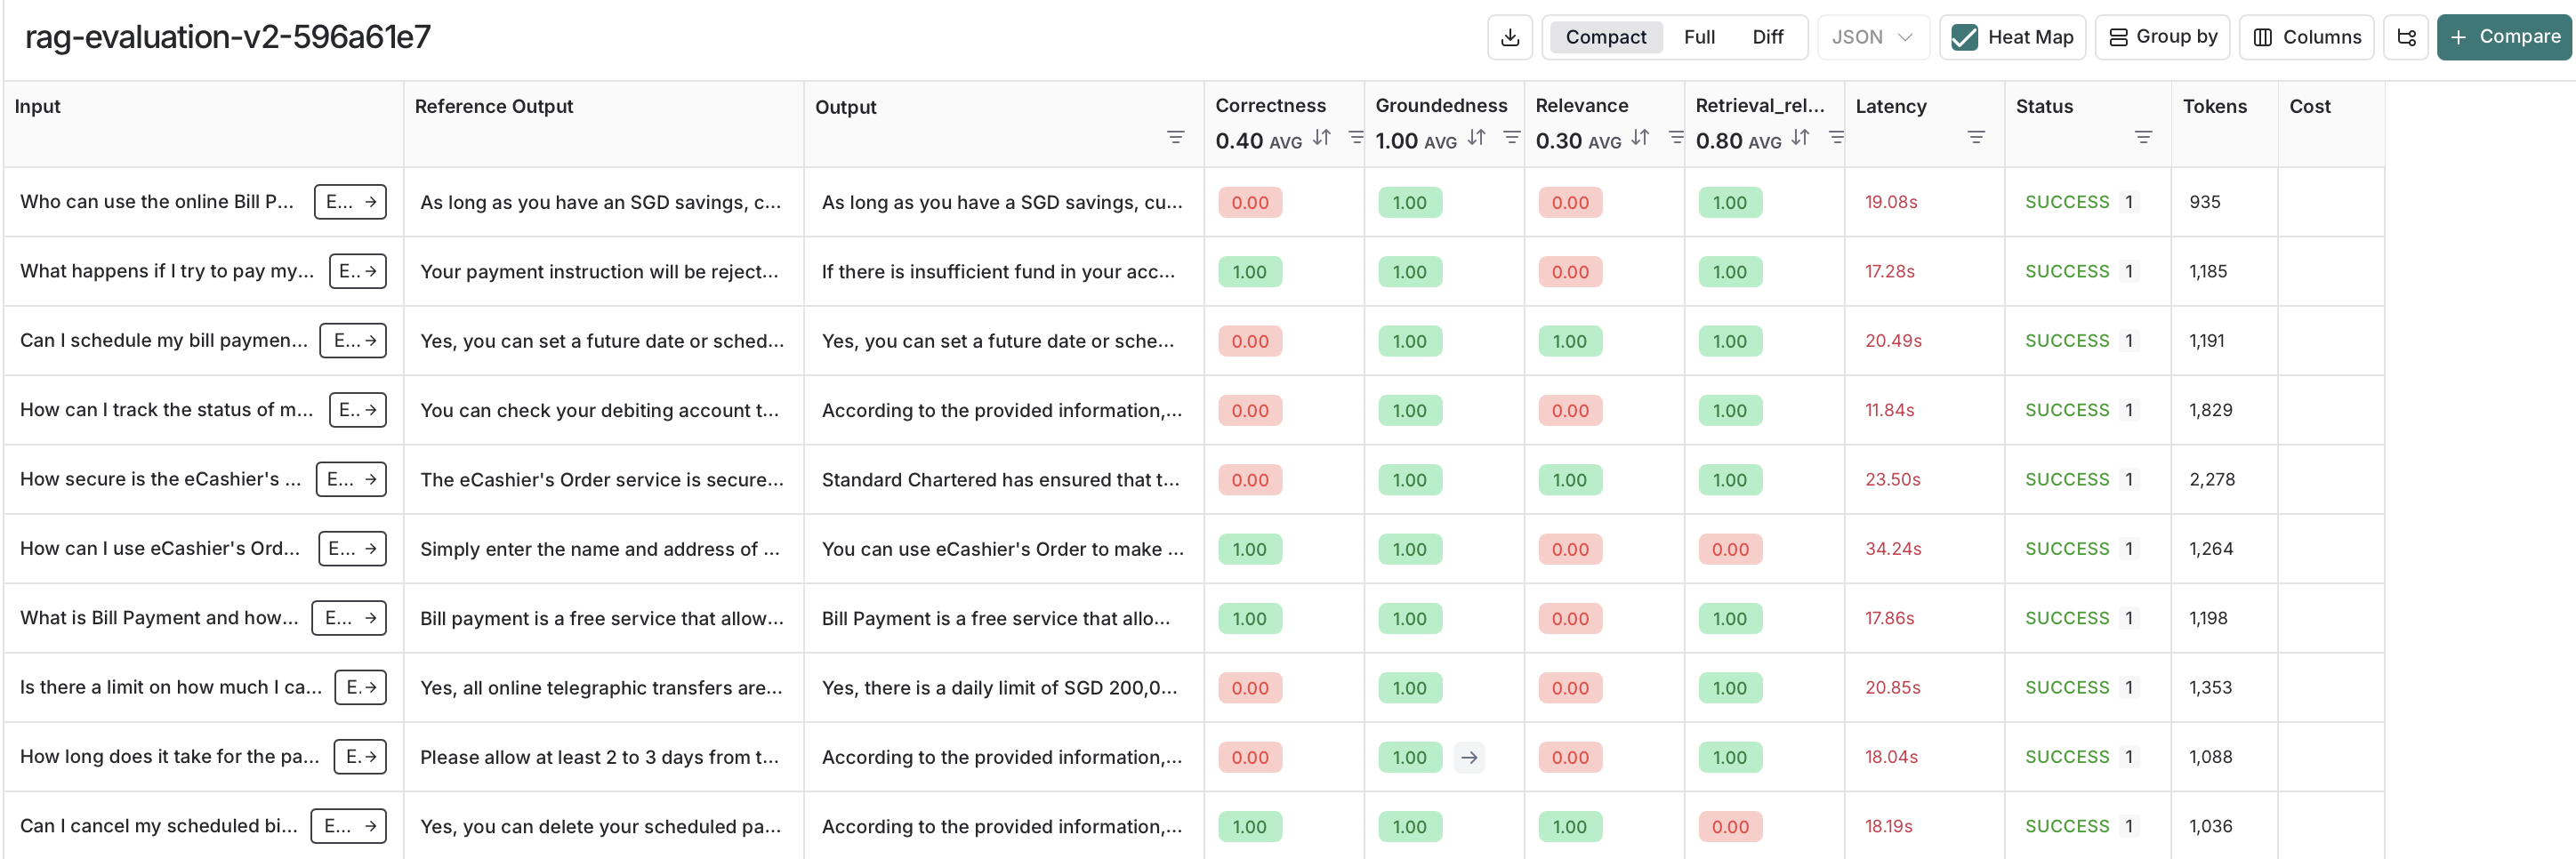

High score in groundness is expected because of the implementation of  Guardrail Verification. High retrieval relevancy is also kind of expecetd since we have HyDE that helps with retrieving the right chuncks. Low relevance is a little surprising given the high retrieval relevancy and the reason might lie in the llm that eventually generates response. Correctness might be the main direction to improve in the future, if the prompt is for correctness checking is at its best. I did spent quite some time trying to get suitable prompt for LLM as judge, as the fair prompts should neither be too strict nor too lenient for judging. Key lessons learned: LLM-based evaluation requires careful prompt engineering and validation

If given more time, I will implement more specific metrics such as BERTScore.

## Discussion
Strengths:
*   Langchain framework gives seamless integration of implementation of various methods.

*   Use HyDE to help with interpreting customer questions and document retrieval.

*   Implemented Guardrail Verification to prevent LLM hallucination, especially for task of finance that people trusting LLM's hallucination could lead to serious consequences.

*   Reusable Framework: Modular design allows easy adaptation to new datasets or evaluation criteria.

Weaknesses:

*   Static Dataset: Fixed evaluation examples may not capture real-world query distribution.
*   Could have more document to give more diverse information for retrieval, with implementatoin of weighting mechanism to determine importance of each document in the case of conflicting information

Improvements & Future Directions:

*   Hybrid Evaluation: Combine LLM-based metrics with traditional NLP metrics (BLEU, ROUGE)
*   Dynamic Dataset Generation: Implement synthetic query generation for broader content coverage and difficulty coverage
*   Human-in-the-Loop: Add manual validation for edge cases through LangSmith UI
*   Multi-dimensional Scoring: Introduce 5-point scales instead of binary true/false (with this also need to consider if LLM is certain bias in interpreting scores eg. LLM may believe in difference between 4 and 5 is smaller than difference between 3 and 4, non-uniform interpretation of scores)
*   Domain-Specific Metrics: Incorporate financial compliance checks (e.g., disclaimer verification)
*   Performance Optimization: Parallelize evaluator calls using async processing

*   Continuous Evaluation: establishing a systematic process to automatically test and validate your RAG system whenever components are updated, ensuring changes don't degrade performance.












